In [1]:
t5dir = "../loss_T5_monomer"
esm2dir = "../loss_ESM2_monomer"

import os
import numpy as np
import json

t5_dict = {}
esm2_dict = {}

for filename in os.listdir(t5dir)[:3]:
    if filename.endswith(".json"):
        uniprot_id = filename.split(".")[0]
        with open(os.path.join(t5dir, filename)) as f:
            data = json.load(f)
            t5_dict[uniprot_id] = data[uniprot_id]

for filename in os.listdir(esm2dir)[:3]:
    if filename.endswith(".json"):
        uniprot_id = filename.split(".")[0]
        with open(os.path.join(esm2dir, filename)) as f:
            data = json.load(f)
            esm2_dict[uniprot_id] = data[uniprot_id]    

In [2]:
common_uniprots = sorted(set.intersection(set(t5_dict.keys()), set(esm2_dict.keys())))[:3]
common_uniprots

['1D2SA', '1GUIA', '1IIBA']

In [3]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('../models/prottrans_t5_xl_u50', do_lower_case=False, legacy=False)

from Bio import SeqIO

fasta_dict = dict()
for record in SeqIO.parse("../monomer_OK_fullset.fasta", "fasta"):
    fasta_dict[record.id] = str(record.seq)

diso_dict = dict()
for record in SeqIO.parse("../monomer_OK_fullset_annotations.fasta", "fasta"):
    diso_dict[record.id] = str(record.seq)

In [4]:
import esm
import torch

# Load model and tokenizer (Avoid loading entire model)
#model, alphabet = esm.pretrained.esm2_t36_3B_UR50D()
alphabet = esm.data.Alphabet.from_architecture("ESM-1b")

In [5]:
import re
from torch.nn import CrossEntropyLoss

celoss = CrossEntropyLoss()
batch_converter = alphabet.get_batch_converter()

def get_single_aa_losses(datadict, prot_tokens):
    all_loss_sequences = []
    logits = datadict['aamask_1']['logits']
    for i in range(len(prot_tokens)):
        aaloss_sequence = []
        if datadict['aamask_1']['loss'][i] < 0:
            aaloss_sequence.append(-1)
        else:
            for j in range(len(prot_tokens)):
                loss = celoss(torch.tensor(logits[i][j]), torch.tensor(prot_tokens[j]))   
                aaloss_sequence.append(loss.item())
        all_loss_sequences.append(aaloss_sequence)
    return all_loss_sequences

def get_single_aa_losses_indiv(logits, prot_tokens):
    aaloss_sequence = []
    for j in range(len(prot_tokens)):
        loss = celoss(torch.tensor(logits[j]), torch.tensor(prot_tokens[j]))   
        aaloss_sequence.append(loss.item())
    return aaloss_sequence



data_loss_sequences = dict()
for unip in common_uniprots:
    input_seq = " ".join(list(re.sub(r"[UZOB]", "X", fasta_dict[unip])))
    T5_prot_toks = tokenizer(input_seq)['input_ids'][:-1] ## remove end of sequence token
    batch_labels, batch_strs, batch_tokens = batch_converter([(uniprot_id, input_seq)])

    ESM2_prot_toks = batch_tokens.squeeze()[1:-1].numpy().tolist() ## remove start and end of sequence token
    print(unip, len(T5_prot_toks))

   

    T5_aaloss_sequences = get_single_aa_losses(t5_dict[unip], T5_prot_toks)
    ESM2_aaloss_sequences = get_single_aa_losses(esm2_dict[unip], ESM2_prot_toks)
    
    T5_prot_loss_sequence = t5_dict[unip]['aamask_1']['loss']
    ESM2_prot_loss_sequence = esm2_dict[unip]['aamask_1']['loss']
    
    data_loss_sequences[unip] = dict()
    data_loss_sequences[unip]['T5'] = dict()
    data_loss_sequences[unip]['ESM2'] = dict()
    data_loss_sequences[unip]['T5']['tokens'] = T5_prot_toks
    data_loss_sequences[unip]['ESM2']['tokens'] = ESM2_prot_toks
    data_loss_sequences[unip]['T5']['aa'] = T5_aaloss_sequences
    data_loss_sequences[unip]['ESM2']['aa'] = ESM2_aaloss_sequences
    data_loss_sequences[unip]['T5']['prot'] = T5_prot_loss_sequence
    data_loss_sequences[unip]['ESM2']['prot'] = ESM2_prot_loss_sequence

    t5_dict[unip]['unmasked_logits'] = torch.load(os.path.join(t5dir, "logits", unip + "_logits.pt"))
    esm2_dict[unip]['unmasked_logits'] = torch.load(os.path.join(esm2dir, "logits", unip + "_logits.pt"))
    data_loss_sequences[unip]['T5']['unmasked_loss'] = get_single_aa_losses_indiv(t5_dict[unip]['unmasked_logits'].squeeze(), T5_prot_toks)
    data_loss_sequences[unip]['ESM2']['unmasked_loss'] = get_single_aa_losses_indiv(esm2_dict[unip]['unmasked_logits'].squeeze(), ESM2_prot_toks)
    

1D2SA 170


/tmp/ipykernel_1584070/1754391141.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = celoss(torch.tensor(logits[j]), torch.tensor(prot_tokens[j]))


1GUIA 155
1IIBA 106


In [6]:
print(len(ESM2_prot_toks))
print(np.array(data_loss_sequences[unip]['T5']['aa']).shape)
print(np.array(data_loss_sequences[unip]['T5']['prot']).shape)
print(np.array(data_loss_sequences[unip]['ESM2']['aa']).shape)
print(np.array(data_loss_sequences[unip]['ESM2']['prot']).shape)

106
(106, 106)
(106,)
(106, 106)
(106,)


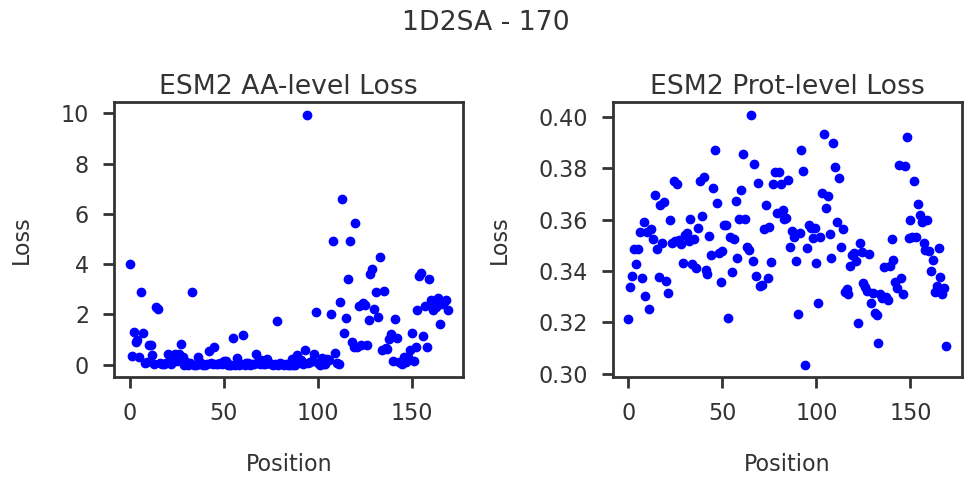

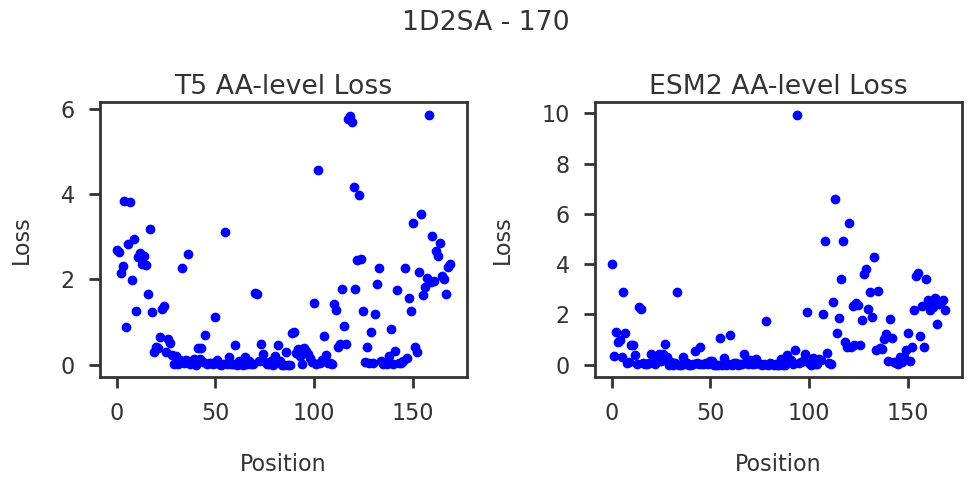

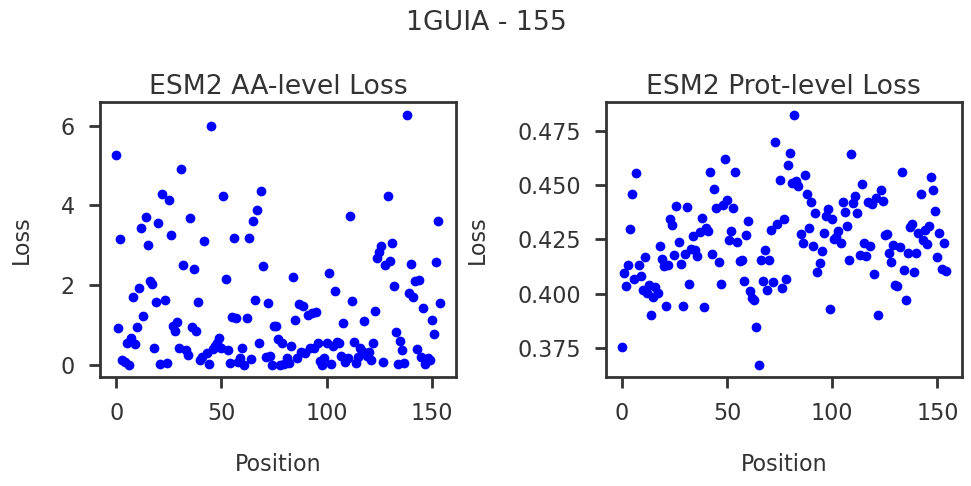

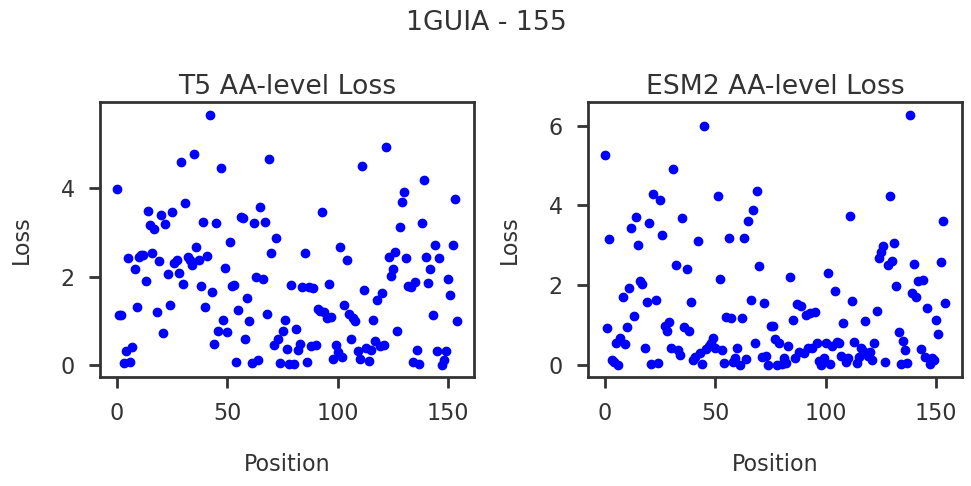

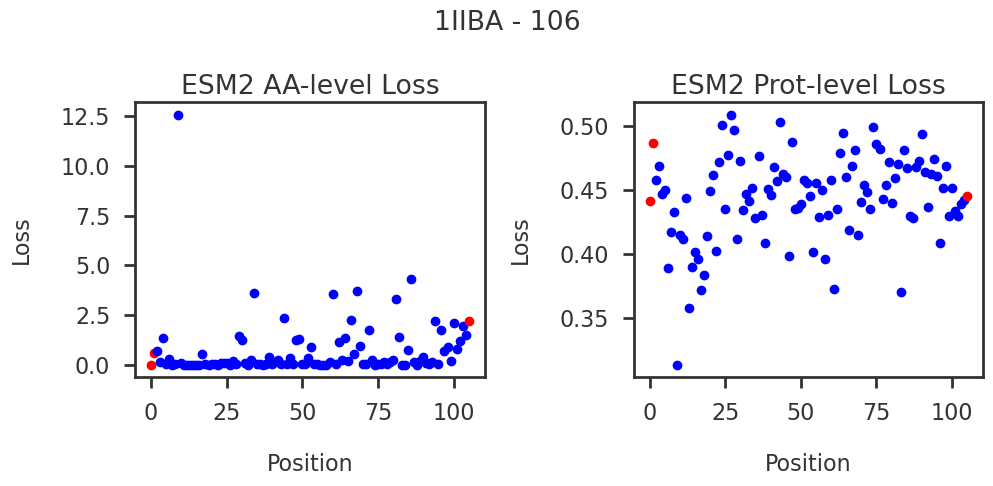

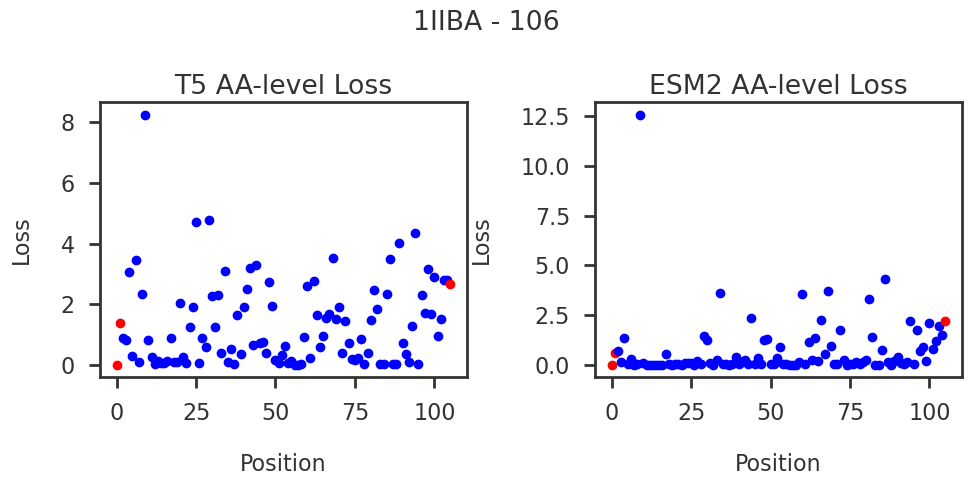

In [7]:
import matplotlib.pyplot as plt
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 16)

def get_position_colors(unip, diso_dict):
    aa_colors = []
    for e in diso_dict[unip]:
        if e == "-":
            aa_colors.append('b')
        else:
            aa_colors.append('r')
    return aa_colors

#unip = common_uniprots[0]
plotdir = "../plots/T5_vs_ESM2_monomer"
os.makedirs(plotdir, exist_ok=True)
for unip in common_uniprots:
    T5_toks   = data_loss_sequences[unip]['T5']['tokens']
    ESM2_toks = data_loss_sequences[unip]['ESM2']['tokens']

    T5_aaloss_sequences = data_loss_sequences[unip]['T5']['aa']
    ESM2_aaloss_sequences = data_loss_sequences[unip]['ESM2']['aa']

    ESM2_prot_loss_sequence = data_loss_sequences[unip]['ESM2']['prot']

    aa_colors = get_position_colors(unip, diso_dict)

    fig = plt.figure(figsize=(10, 5), dpi=100)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    for i in range(len(ESM2_toks)):
        ax1.scatter(i, ESM2_aaloss_sequences[i][i], color=aa_colors[i])
        ax2.scatter(i, ESM2_prot_loss_sequence[i], color=aa_colors[i])
    ax1.set_ylabel("Loss") 
    ax1.set_xlabel("Position")
    ax2.set_ylabel("Loss") 
    ax2.set_xlabel("Position")
    ax1.set_title("ESM2 AA-level Loss")
    ax2.set_title("ESM2 Prot-level Loss")
    plt.suptitle(f"{unip} - {len(fasta_dict[unip])}")
    plt.tight_layout() #rect=[0, 0, 1, 1])
    plt.savefig(f"{plotdir}/ESM2_prot_vs_aa_loss_{unip}.png")
    plt.show()


    fig = plt.figure(figsize=(10, 5), dpi=100)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    for i in range(len(T5_toks)):
        ax1.scatter(i, T5_aaloss_sequences[i][i], color=aa_colors[i])
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Position")
    ax1.set_title("T5 AA-level Loss")
    for i in range(len(ESM2_toks)):
        ax2.scatter(i, ESM2_aaloss_sequences[i][i], color=aa_colors[i])
    ax2.set_ylabel("Loss") 
    ax2.set_xlabel("Position")
    ax2.set_title("ESM2 AA-level Loss")
    plt.suptitle(f"{unip} - {len(fasta_dict[unip])}")
    plt.tight_layout() #rect=[0, 0, 1, 1])
    plt.savefig(f"{plotdir}/position_loss_comparison_{unip}.png")
    plt.show()


    # ESM2_aaloss_unmasked_sequence = data_loss_sequences[unip]['ESM2']['unmasked_loss']
    # T5_aaloss_unmasked_sequence   = data_loss_sequences[unip]['T5']['unmasked_loss']
    # fig = plt.figure(figsize=(10, 5), dpi=100)
    # ax1 = fig.add_subplot(121)
    # ax2 = fig.add_subplot(122)
    # for i in range(len(T5_toks)):
    #     ax1.scatter(i, T5_aaloss_unmasked_sequence[i], color=aa_colors[i])
    # ax1.set_ylabel("Loss")
    # ax1.set_xlabel("Position")
    # ax1.set_title("T5 AA-level unmasked Loss")
    # for i in range(len(ESM2_toks)):
    #     ax2.scatter(i, ESM2_aaloss_unmasked_sequence[i], color=aa_colors[i])
    # ax2.set_ylabel("Loss") 
    # ax2.set_xlabel("Position")
    # ax2.set_title("ESM2 AA-level unmasked Loss")
    # plt.suptitle(f"{unip} - {len(fasta_dict[unip])}")
    # plt.tight_layout() #rect=[0, 0, 1, 1])
    # plt.savefig(f"{plotdir}/position_unmasked_loss_comparison_{unip}.png")
    # plt.show()


    # fig = plt.figure(figsize=(6, 6), dpi=100)
    # ax1 = fig.add_subplot(111)

    # for i in range(len(T5_toks)):
    #     ax1.scatter(ESM2_aaloss_sequences[i][i], T5_aaloss_sequences[i][i], color=aa_colors[i])
    # ax1.set_ylabel("T5 Loss")
    # ax1.set_xlabel("ESM2 Loss")
    # ax1.set_title("AA-level Loss")
    # plt.suptitle(f"{unip} - {len(fasta_dict[unip])}")
    # plt.tight_layout() #rect=[0, 0, 1, 1])
    # plt.savefig(f"../plots/T5_vs_ESM2/loss_comparison_{unip}.png")
    # plt.show()


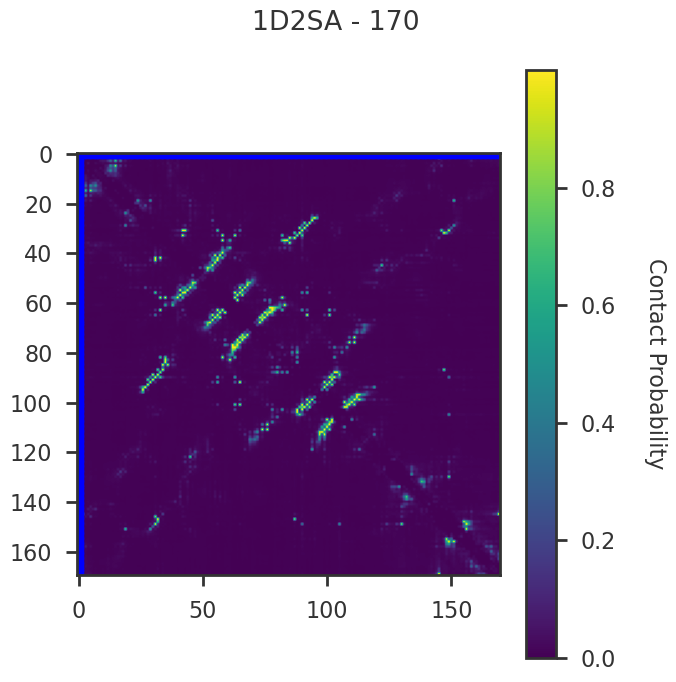

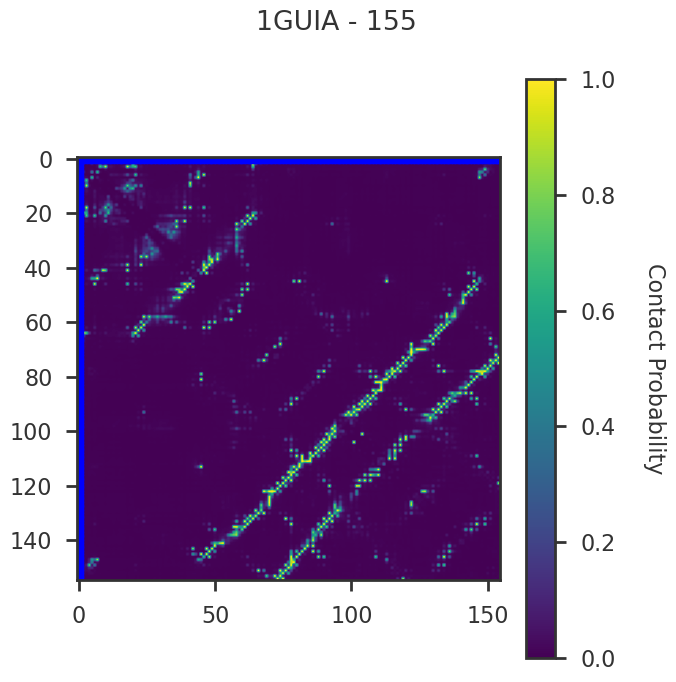

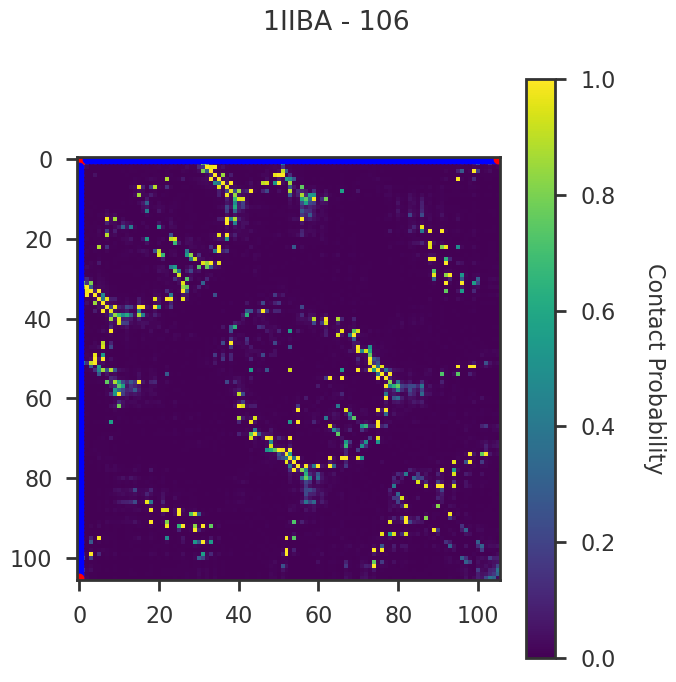

In [8]:

for unip in common_uniprots:
    contacts = torch.load(f"../loss_ESM2_monomer/logits/{unip}_contacts.pt")
    aa_colors = get_position_colors(unip, diso_dict)    
    fig = plt.figure(figsize=(7, 7), dpi=100) 
    ax  = fig.add_subplot(111)
    im  = ax.imshow(contacts)
    # paint a row with aa_colors
    for i in range(len(aa_colors)):
        ax.scatter(i, 0, color=aa_colors[i])
        ax.scatter(0, i, color=aa_colors[i])
    #add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Contact Probability", rotation=-90, va="bottom")
    plt.suptitle(f"{unip} - {len(fasta_dict[unip])}")
    plt.tight_layout()
    plt.savefig(f"../plots/T5_vs_ESM2/contacts_{unip}.png")
    plt.show()
    

In [9]:
from math import log2
 
# calculate the kl divergence KL(P || Q)
def kl_divergence(p, q):
 return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))
 
# calculate entropy H(P)
def entropy(p):
 return -sum([p[i] * log2(p[i]) for i in range(len(p))])
 
# calculate cross entropy H(P, Q)
def cross_entropy(p, q):
 return entropy(p) + kl_divergence(p, q)


testP = [0.1, 0.2, 0.7] 
testQ = [1e-5, 1e-5, 1.0-2e-5]

print(entropy(testP), entropy(testQ))

1.1567796494470395 0.00036104642176561263


In [10]:
## read dictionaries from json
with open("disprot_disorder_distrib_dict.json") as f:
    disprot_disorder_distrib_dict = json.load(f)

with open("disprot_order_distrib_dict.json") as f:
    disprot_order_distrib_dict = json.load(f)

with open("monomer_disorder_distrib_dict.json") as f:
    monomer_disorder_distrib_dict = json.load(f)

with open("monomer_order_distrib_dict.json") as f:
    monomer_order_distrib_dict = json.load(f)

disprot_disorder_distrib_dict


{'M': 3860,
 'Q': 9613,
 'R': 10121,
 'G': 14774,
 'N': 8100,
 'F': 4819,
 'K': 13654,
 'E': 16624,
 'A': 15133,
 'L': 12449,
 'I': 6193,
 'W': 1307,
 'P': 13315,
 'S': 17346,
 'Y': 3831,
 'D': 11943,
 'T': 10413,
 'H': 3840,
 'V': 8954,
 'C': 1701,
 'Z': 1}

In [11]:
T5_vocab = [ i[1] for i in tokenizer.get_vocab().keys() if i.startswith("▁") and not re.search(r"[UZOBX]", i)] # this is not a regular underscore char
T5_vocab_ix = [ j for j,i in enumerate(tokenizer.get_vocab().keys()) if i.startswith("▁") and not re.search(r"[UZOBX]", i)]
print(len(T5_vocab), len(T5_vocab_ix))
print(T5_vocab, T5_vocab_ix)

ESM2_vocab = [i for i in alphabet.all_toks if len(i) == 1 and not re.search(r"[UZOBX\.-]", i)]
ESM2_vocab_ix = [j for j,i in enumerate(alphabet.all_toks) if len(i) == 1 and not re.search(r"[UZOBX\.-]", i)]
print(len(ESM2_vocab))
print(ESM2_vocab,  ESM2_vocab_ix)

20 20
['A', 'L', 'G', 'V', 'S', 'R', 'E', 'D', 'T', 'I', 'P', 'K', 'F', 'Q', 'N', 'Y', 'M', 'H', 'W', 'C'] [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
20
['L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C'] [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [12]:

disprot_disorder_distrib_T5 = [disprot_disorder_distrib_dict[i] for i in T5_vocab if i in disprot_disorder_distrib_dict]
disprot_order_distrib_T5 = [disprot_order_distrib_dict[i] for i in T5_vocab if i in disprot_order_distrib_dict]
monomer_disorder_distrib_T5 = [monomer_disorder_distrib_dict[i] for i in T5_vocab if i in monomer_disorder_distrib_dict]
monomer_order_distrib_T5 = [monomer_order_distrib_dict[i] for i in T5_vocab if i in monomer_order_distrib_dict]


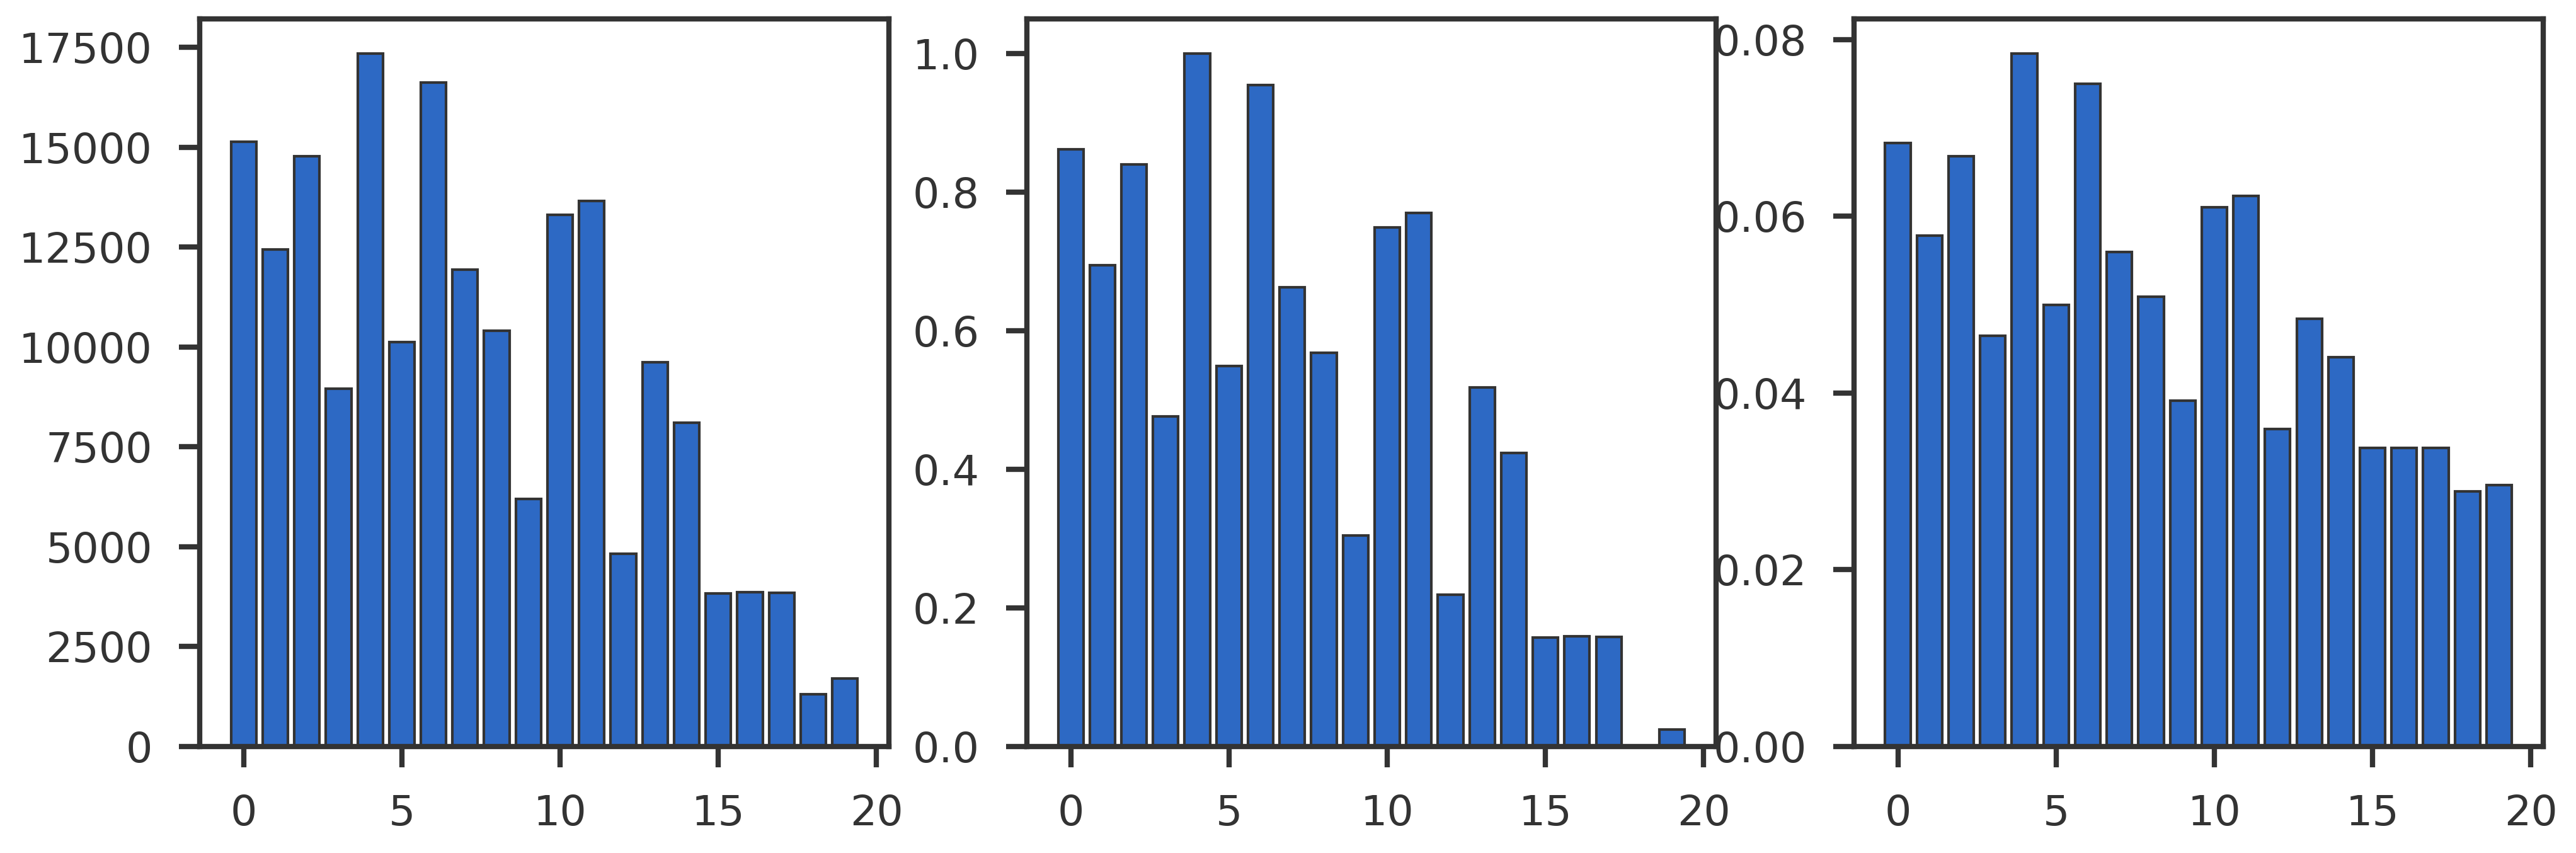

In [13]:
def minmax_normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def custom_softmax(x):
    softmax = torch.nn.Softmax(dim=1)
    norm = minmax_normalize(x)
    return softmax(torch.Tensor(norm).unsqueeze(0))

disprot_disorder_distrib_T5_norm = minmax_normalize(disprot_disorder_distrib_T5)
disprot_disorder_distrib_T5_probs = custom_softmax(disprot_disorder_distrib_T5)

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.bar(np.arange(len(disprot_disorder_distrib_T5)), height=disprot_disorder_distrib_T5)
ax2.bar(np.arange(len(disprot_disorder_distrib_T5)), height=disprot_disorder_distrib_T5_norm)
ax3.bar(np.arange(len(disprot_disorder_distrib_T5)), height=disprot_disorder_distrib_T5_probs.squeeze().detach().numpy())
plt.show()

1D2SA 170 170
PPAVHLSNGPGQEPIAVMTFDLTKITKTSSSFEVRTWDPEGVIFYGDTNPKDDWFMLGLRDGRPEIQLHNHWAQLTVGAGPRLDDGRWHQVEVKMEGDSVLLEVDGEEVLRLRQVSGHPIMRIALGGLLFPASNLRLPLVPALDGCLRRDSWLDKQAEISASAPTSLRSC
[13, 13, 3, 6, 20, 4, 7, 17, 5, 13, 5, 16, 9, 13, 12, 3, 6, 19, 11, 15, 10, 4, 11, 14, 12, 11, 14, 11, 7, 7, 7, 15, 9, 6, 8, 11, 21, 10, 13, 9, 5, 6, 12, 15, 18, 5, 10, 11, 17, 13, 14, 10, 10, 21, 15, 19, 4, 5, 4, 8, 10, 5, 8, 13, 9, 12, 16, 4, 20, 17, 20, 21, 3, 16, 4, 11, 6, 5, 3, 5, 13, 8, 4, 10, 10, 5, 8, 21, 20, 16, 6, 9, 6, 14, 19, 9, 5, 10, 7, 6, 4, 4, 9, 6, 10, 5, 9, 9, 6, 4, 8, 4, 8, 16, 6, 7, 5, 20, 13, 12, 19, 8, 12, 3, 4, 5, 5, 4, 4, 15, 13, 3, 7, 17, 4, 8, 4, 13, 4, 6, 13, 3, 4, 10, 5, 22, 4, 8, 8, 10, 7, 21, 4, 10, 14, 16, 3, 9, 12, 7, 3, 7, 3, 13, 11, 7, 4, 8, 7, 22]


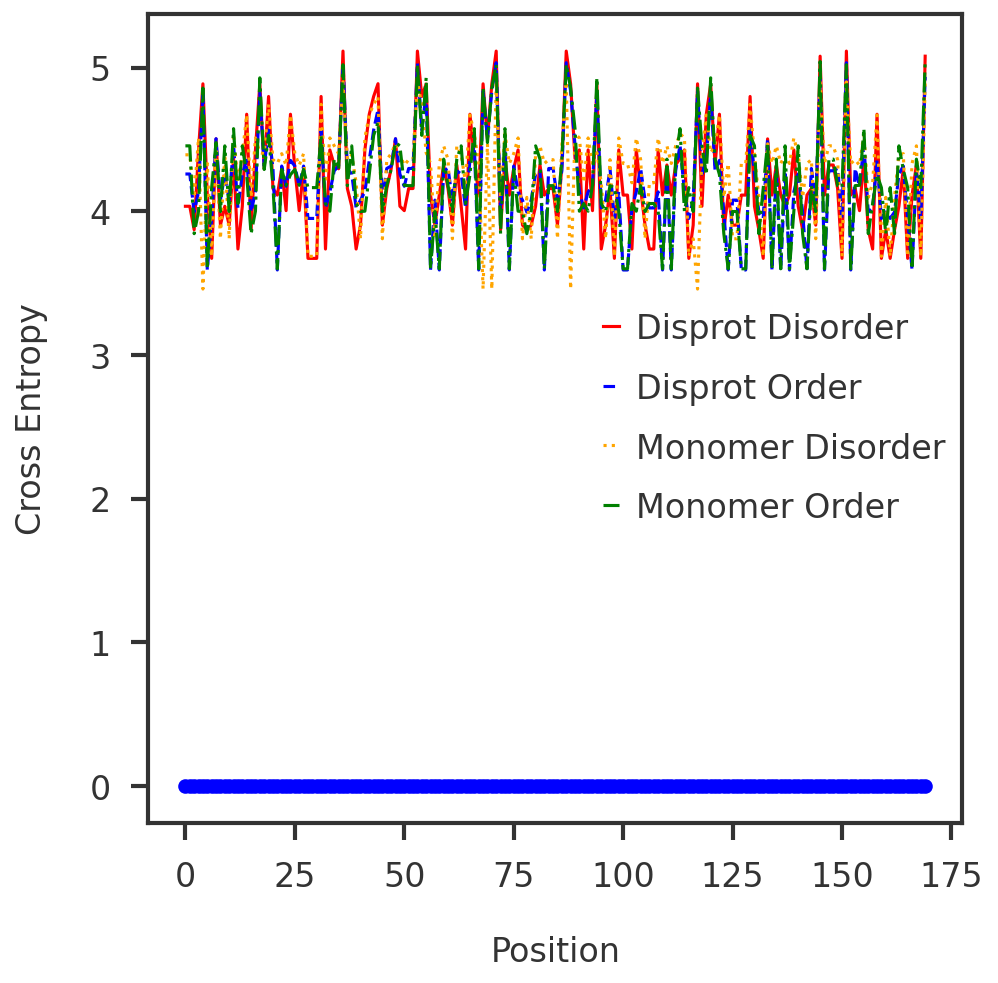

In [28]:
celoss = CrossEntropyLoss()
from torch.distributions import Categorical

# p_tensor = torch.Tensor([0.1, 0.2, 0.4, 0.3])
# entropy2 = Categorical(probs = p_tensor).entropy()

def cross_entropy_logits(logits, distrib_prob, vocab_ix):
    ce_sequence = []
    softmax = torch.nn.Softmax(dim=1)
    for j in range(logits.shape[0]):
        tmp = softmax(logits[j][vocab_ix].unsqueeze(0))
        ce = cross_entropy(tmp.squeeze().numpy(), distrib_prob.squeeze().numpy())
        ce_sequence.append(ce)
    return ce_sequence

data_entropy_sequences = dict()
disprot_disorder_distrib_T5_probs = custom_softmax(disprot_disorder_distrib_T5)
disprot_order_distrib_T5_probs = custom_softmax(disprot_order_distrib_T5)
monomer_disorder_distrib_T5_probs = custom_softmax(monomer_disorder_distrib_T5)
monomer_order_distrib_T5_probs = custom_softmax(monomer_order_distrib_T5)

for unip in common_uniprots:

    T5_prot_toks = data_loss_sequences[unip]['T5']['tokens']
    ESM2_prot_toks = data_loss_sequences[unip]['ESM2']['tokens']
    print(unip, len(T5_prot_toks), len(ESM2_prot_toks))
    aa_colors = get_position_colors(unip, diso_dict)
    print(fasta_dict[unip])
    print(T5_prot_toks)

    ce_disprot_disorder = cross_entropy_logits(t5_dict[unip]['unmasked_logits'].squeeze(), disprot_disorder_distrib_T5_probs, T5_vocab_ix)
    ce_disprot_sorder   = cross_entropy_logits(t5_dict[unip]['unmasked_logits'].squeeze(), disprot_order_distrib_T5_probs, T5_vocab_ix)
    ce_monomer_disorder = cross_entropy_logits(t5_dict[unip]['unmasked_logits'].squeeze(), monomer_disorder_distrib_T5_probs, T5_vocab_ix)
    ce_monomer_order    = cross_entropy_logits(t5_dict[unip]['unmasked_logits'].squeeze(), monomer_order_distrib_T5_probs, T5_vocab_ix)

    fig = plt.figure(figsize=(7,7), dpi=150)
    ax1 = fig.add_subplot(111)
    ax1.plot(ce_disprot_disorder, label="Disprot Disorder", color="red", linestyle="solid")
    ax1.plot(ce_disprot_sorder, label="Disprot Order", color="blue", linestyle="dashed")
    ax1.plot(ce_monomer_disorder, label="Monomer Disorder", color="orange", linestyle="dotted")
    ax1.plot(ce_monomer_order, label="Monomer Order", color="green", linestyle="dashdot")
    for i in range(len(aa_colors)):
        ax1.scatter(i, 0, color=aa_colors[i])
    ax1.set_ylabel("Cross Entropy")
    ax1.set_xlabel("Position")
    ax1.legend()
    plt.show()
    
    break

In [29]:
aa_ix = [i for i,aa in enumerate(fasta_dict[unip]) if aa == "R"]
aa_ix

[34, 59, 62, 81, 86, 110, 112, 121, 135, 147, 148, 167]

1D2SA 170 170
PPAVHLSNGPGQEPIAVMTFDLTKITKTSSSFEVRTWDPEGVIFYGDTNPKDDWFMLGLRDGRPEIQLHNHWAQLTVGAGPRLDDGRWHQVEVKMEGDSVLLEVDGEEVLRLRQVSGHPIMRIALGGLLFPASNLRLPLVPALDGCLRRDSWLDKQAEISASAPTSLRSC
[13, 13, 3, 6, 20, 4, 7, 17, 5, 13, 5, 16, 9, 13, 12, 3, 6, 19, 11, 15, 10, 4, 11, 14, 12, 11, 14, 11, 7, 7, 7, 15, 9, 6, 8, 11, 21, 10, 13, 9, 5, 6, 12, 15, 18, 5, 10, 11, 17, 13, 14, 10, 10, 21, 15, 19, 4, 5, 4, 8, 10, 5, 8, 13, 9, 12, 16, 4, 20, 17, 20, 21, 3, 16, 4, 11, 6, 5, 3, 5, 13, 8, 4, 10, 10, 5, 8, 21, 20, 16, 6, 9, 6, 14, 19, 9, 5, 10, 7, 6, 4, 4, 9, 6, 10, 5, 9, 9, 6, 4, 8, 4, 8, 16, 6, 7, 5, 20, 13, 12, 19, 8, 12, 3, 4, 5, 5, 4, 4, 15, 13, 3, 7, 17, 4, 8, 4, 13, 4, 6, 13, 3, 4, 10, 5, 22, 4, 8, 8, 10, 7, 21, 4, 10, 14, 16, 3, 9, 12, 7, 3, 7, 3, 13, 11, 7, 4, 8, 7, 22]


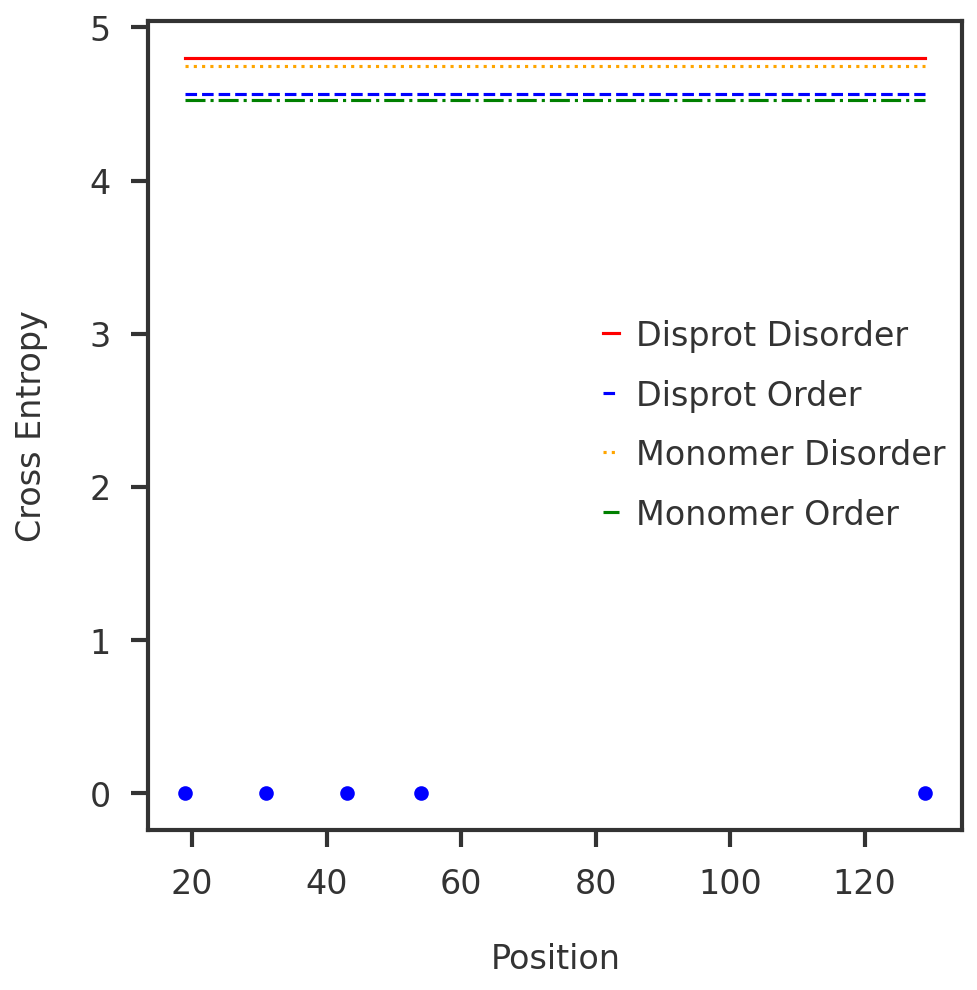

In [31]:
## Do the same but only for a specific aminoacid

for unip in common_uniprots:

    T5_prot_toks = data_loss_sequences[unip]['T5']['tokens']
    ESM2_prot_toks = data_loss_sequences[unip]['ESM2']['tokens']
    print(unip, len(T5_prot_toks), len(ESM2_prot_toks))
    aa_colors = get_position_colors(unip, diso_dict)
    print(fasta_dict[unip])
    print(T5_prot_toks)

    aa_ix = [i for i,aa in enumerate(fasta_dict[unip]) if aa == "F"]


    ce_disprot_disorder = cross_entropy_logits(t5_dict[unip]['unmasked_logits'].squeeze()[aa_ix], disprot_disorder_distrib_T5_probs, T5_vocab_ix)
    ce_disprot_sorder   = cross_entropy_logits(t5_dict[unip]['unmasked_logits'].squeeze()[aa_ix], disprot_order_distrib_T5_probs, T5_vocab_ix)
    ce_monomer_disorder = cross_entropy_logits(t5_dict[unip]['unmasked_logits'].squeeze()[aa_ix], monomer_disorder_distrib_T5_probs, T5_vocab_ix)
    ce_monomer_order    = cross_entropy_logits(t5_dict[unip]['unmasked_logits'].squeeze()[aa_ix], monomer_order_distrib_T5_probs, T5_vocab_ix)

    fig = plt.figure(figsize=(7,7), dpi=150)
    ax1 = fig.add_subplot(111)
    ax1.plot(aa_ix,ce_disprot_disorder, label="Disprot Disorder", color="red", linestyle="solid")
    ax1.plot(aa_ix,ce_disprot_sorder, label="Disprot Order", color="blue", linestyle="dashed")
    ax1.plot(aa_ix,ce_monomer_disorder, label="Monomer Disorder", color="orange", linestyle="dotted")
    ax1.plot(aa_ix,ce_monomer_order, label="Monomer Order", color="green", linestyle="dashdot")
    for i in aa_ix:
        ax1.scatter(i, 0, color=aa_colors[i])
    ax1.set_ylabel("Cross Entropy")
    ax1.set_xlabel("Position")
    ax1.legend()
    plt.show()
    
    break

1D2SA 170 170
PPAVHLSNGPGQEPIAVMTFDLTKITKTSSSFEVRTWDPEGVIFYGDTNPKDDWFMLGLRDGRPEIQLHNHWAQLTVGAGPRLDDGRWHQVEVKMEGDSVLLEVDGEEVLRLRQVSGHPIMRIALGGLLFPASNLRLPLVPALDGCLRRDSWLDKQAEISASAPTSLRSC
[13, 13, 3, 6, 20, 4, 7, 17, 5, 13, 5, 16, 9, 13, 12, 3, 6, 19, 11, 15, 10, 4, 11, 14, 12, 11, 14, 11, 7, 7, 7, 15, 9, 6, 8, 11, 21, 10, 13, 9, 5, 6, 12, 15, 18, 5, 10, 11, 17, 13, 14, 10, 10, 21, 15, 19, 4, 5, 4, 8, 10, 5, 8, 13, 9, 12, 16, 4, 20, 17, 20, 21, 3, 16, 4, 11, 6, 5, 3, 5, 13, 8, 4, 10, 10, 5, 8, 21, 20, 16, 6, 9, 6, 14, 19, 9, 5, 10, 7, 6, 4, 4, 9, 6, 10, 5, 9, 9, 6, 4, 8, 4, 8, 16, 6, 7, 5, 20, 13, 12, 19, 8, 12, 3, 4, 5, 5, 4, 4, 15, 13, 3, 7, 17, 4, 8, 4, 13, 4, 6, 13, 3, 4, 10, 5, 22, 4, 8, 8, 10, 7, 21, 4, 10, 14, 16, 3, 9, 12, 7, 3, 7, 3, 13, 11, 7, 4, 8, 7, 22]
128
33
[(168, 'S'), (29, 'S'), (101, 'L'), (6, 'S'), (108, 'V'), (90, 'V'), (132, 'S'), (98, 'S'), (92, 'V'), (152, 'L')]
[(151, 'W'), (49, 'P'), (71, 'W'), (53, 'W'), (80, 'P'), (63, 'P'), (38, 'P'), (137, 'P'), (130, 'P'), (

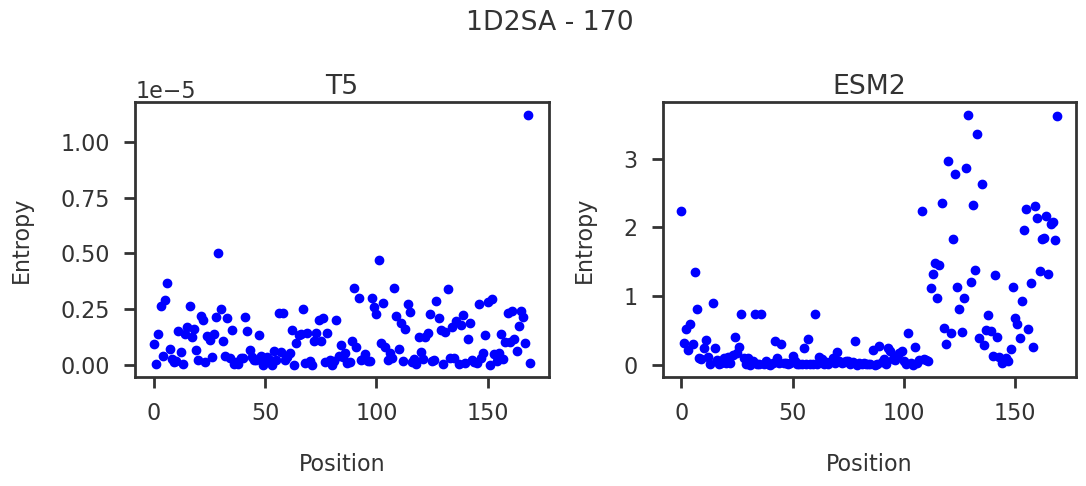

1GUIA 155 155
SINNGTFDEPIVNDQANNPDEWFIWQAGDYGISGARVSDYGVRDGYAYITIADPGTDTWHIQFNQWIGLYRGKTYTISFKAKADTPRPINVKILQNHDPWTNYFAQTVNLTADWQTFTFTYTHPDDADEVVQISFELGEGTATTIYFDDVTVSPQ
[7, 12, 17, 17, 5, 11, 15, 10, 9, 13, 12, 6, 17, 10, 16, 3, 17, 17, 13, 10, 9, 21, 15, 12, 21, 16, 3, 5, 10, 18, 5, 12, 7, 5, 3, 8, 6, 7, 10, 18, 5, 6, 8, 10, 5, 18, 3, 18, 12, 11, 12, 3, 10, 13, 5, 11, 10, 11, 21, 20, 12, 16, 15, 17, 16, 21, 12, 5, 4, 18, 8, 5, 14, 11, 18, 11, 12, 7, 15, 14, 3, 14, 3, 10, 11, 13, 8, 13, 12, 17, 6, 14, 12, 4, 16, 17, 20, 10, 13, 21, 11, 17, 18, 15, 3, 16, 11, 6, 17, 4, 11, 3, 10, 21, 16, 11, 15, 11, 15, 11, 18, 11, 20, 13, 10, 10, 3, 10, 9, 6, 6, 16, 12, 7, 15, 9, 4, 5, 9, 5, 11, 3, 11, 11, 12, 18, 15, 10, 10, 6, 11, 6, 7, 13, 16]
128
33
[(76, 'I'), (119, 'T'), (75, 'T'), (117, 'T'), (0, 'S'), (68, 'L'), (143, 'T'), (77, 'S'), (106, 'T'), (36, 'V')]
[(18, 'P'), (65, 'W'), (53, 'P'), (113, 'W'), (21, 'W'), (87, 'P'), (9, 'P'), (96, 'H'), (24, 'W'), (123, 'P')]


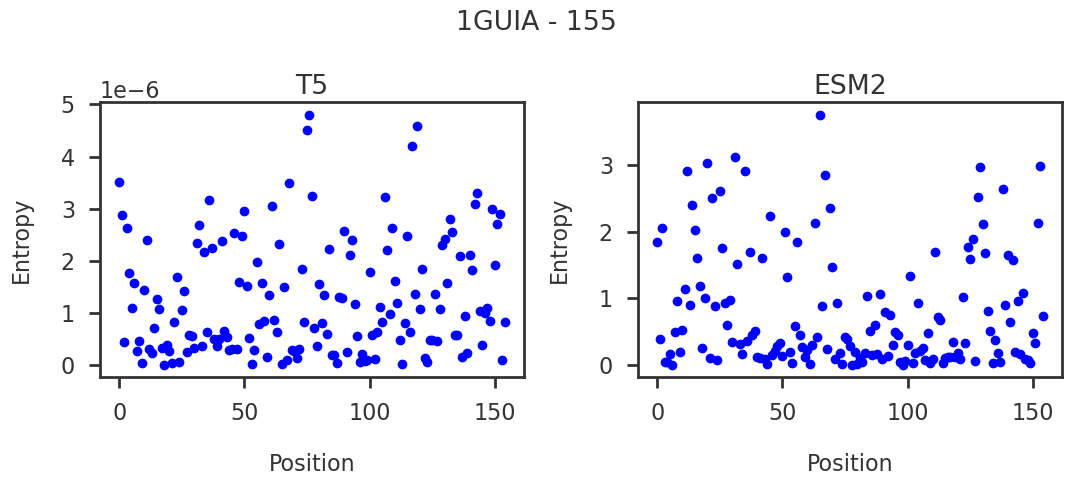

1IIBA 106 106
MEKKHIYLFSSAGMSTSLLVSKMRAQAEKYEVPVIIEAFPETLAGEKGQNADVVLLGPQIAYMLPEIQRLLPNKPVEVIDSLLYGKVDGLGVLKAAVAAIKKAAAN
[19, 9, 14, 14, 20, 12, 18, 4, 15, 7, 7, 3, 5, 19, 7, 11, 7, 4, 4, 6, 7, 14, 19, 8, 3, 16, 3, 9, 14, 18, 9, 6, 13, 6, 12, 12, 9, 3, 15, 13, 9, 11, 4, 3, 5, 9, 14, 5, 16, 17, 3, 10, 6, 6, 4, 4, 5, 13, 16, 12, 3, 18, 19, 4, 13, 9, 12, 16, 8, 4, 4, 13, 17, 14, 13, 6, 9, 6, 12, 10, 7, 4, 4, 18, 5, 14, 6, 10, 5, 4, 5, 6, 4, 14, 3, 3, 6, 3, 3, 12, 14, 14, 3, 3, 3, 17]
128
33
[(9, 'S'), (33, 'V'), (70, 'L'), (102, 'A'), (31, 'V'), (53, 'V'), (96, 'V'), (20, 'S'), (14, 'S'), (5, 'I')]
[(74, 'P'), (64, 'P'), (32, 'P'), (71, 'P'), (39, 'P'), (57, 'P'), (90, 'G'), (83, 'Y'), (46, 'K'), (88, 'G')]


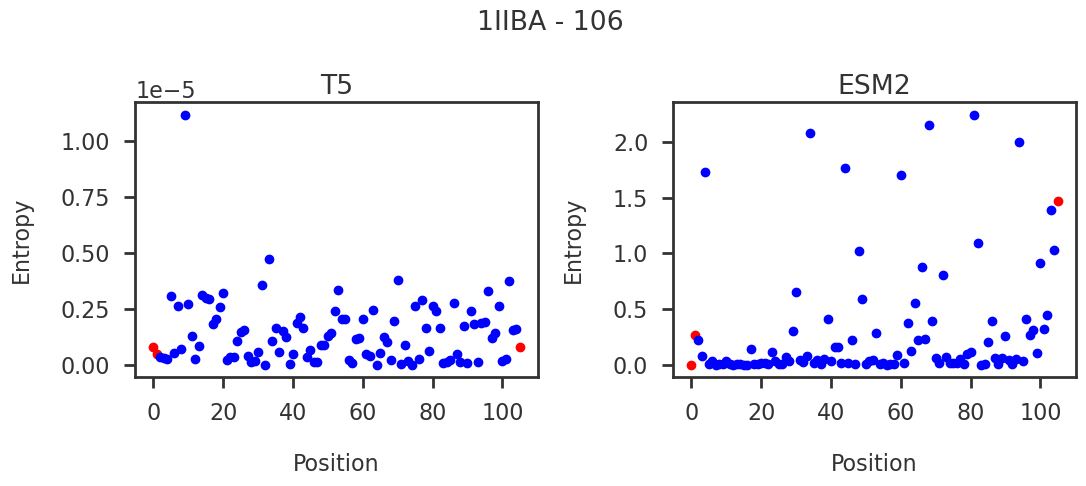

In [32]:
## Calculate entropy for each position

def entropy_logits(logits, vocab_ix):
    e_sequence = []
    softmax = torch.nn.Softmax(dim=1)
    for j in range(logits.shape[0]):
        tmp = softmax(logits[j][vocab_ix].unsqueeze(0))
        e = entropy(tmp.squeeze().numpy())
        e_sequence.append(e)
    return e_sequence

for unip in common_uniprots:

    T5_prot_toks = data_loss_sequences[unip]['T5']['tokens']
    ESM2_prot_toks = data_loss_sequences[unip]['ESM2']['tokens']
    print(unip, len(T5_prot_toks), len(ESM2_prot_toks))
    aa_colors = get_position_colors(unip, diso_dict)
    print(fasta_dict[unip])
    print(T5_prot_toks)

    T5_all_vocab_ix   = [i for i in range(len(tokenizer.get_vocab().keys()))]
    ESM2_all_vocab_ix = [i for i in range(len(alphabet.all_toks))]

    print(len(T5_all_vocab_ix))
    print(len(ESM2_all_vocab_ix))

    entropy_sequence_T5   = entropy_logits(t5_dict[unip]['unmasked_logits'].squeeze(), T5_vocab_ix)
    entropy_sequence_ESM2 = entropy_logits(esm2_dict[unip]['unmasked_logits'].squeeze(), ESM2_vocab_ix)
    ## It didn't work, some math error, but the difference between the above is extremely small
    # entropy_sequence_T5   = entropy_logits(t5_dict[unip]['unmasked_logits'].squeeze()[:-1], T5_all_vocab_ix)
    # entropy_sequence_ESM2 = entropy_logits(esm2_dict[unip]['unmasked_logits'].squeeze()[1:-1], ESM2_all_vocab_ix)

    print([(i,fasta_dict[unip][i]) for i in np.argsort(entropy_sequence_T5)[::-1]][:10])
    print([(i,fasta_dict[unip][i]) for i in np.argsort(entropy_sequence_T5)][:10])

    fig = plt.figure(figsize=(11,5), dpi=100)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    for i in range(len(aa_colors)):
        ax1.scatter(i, entropy_sequence_T5[i], color=aa_colors[i])
        ax2.scatter(i, entropy_sequence_ESM2[i], color=aa_colors[i])
    ax1.set_ylabel("Entropy")
    ax1.set_xlabel("Position")
    ax1.set_title("T5")
    ax2.set_ylabel("Entropy")
    ax2.set_xlabel("Position")
    ax2.set_title("ESM2")
    plt.suptitle(f"{unip} - {len(fasta_dict[unip])}")
    plt.tight_layout()
    plt.show()



In [33]:
print(entropy([0.01, 0.01, 0.01, 0.97]))
print(entropy([0.25, 0.25, 0.25, 0.25]))

0.24194073285321088
2.0


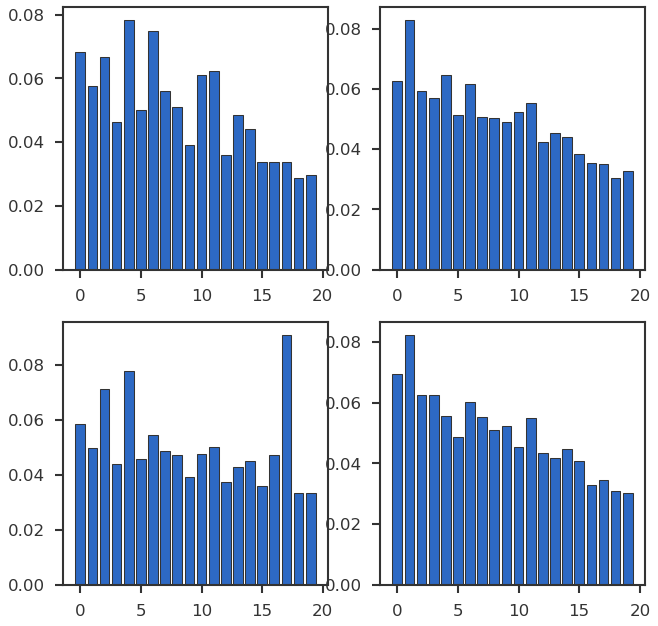

In [35]:
fig = plt.figure(figsize=(10,10), dpi=75)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.bar(np.arange(disprot_disorder_distrib_T5_probs.squeeze().numpy().shape[0]), height=disprot_disorder_distrib_T5_probs.squeeze().numpy() )
ax2.bar(np.arange(disprot_disorder_distrib_T5_probs.squeeze().numpy().shape[0]), height=disprot_order_distrib_T5_probs.squeeze().numpy() )
ax3.bar(np.arange(monomer_disorder_distrib_T5_probs.squeeze().numpy().shape[0]), height=monomer_disorder_distrib_T5_probs.squeeze().numpy() )
ax4.bar(np.arange(monomer_disorder_distrib_T5_probs.squeeze().numpy().shape[0]), height=monomer_order_distrib_T5_probs.squeeze().numpy() )
plt.show()